# Bike sharing demand forecast

This notebook along with the repository contains a simple code to create a `LGBMRegressor` which could be used to predict bike sharing demand.

Dataset was downloaded from Kaggle: https://www.kaggle.com/datasets/imakash3011/rental-bike-sharing


In [1]:
# Dependencies

import pandas as pd
import numpy as np

from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV
)

import sys

from src.features.build_features import trig_transformer, spline_transformer, get_lag_features
from src.visualization import pacf_plot, residual_plot
from src.model.predict_model import make_prediction, evaluate_model

from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
data_path = "/Users/damir_bogdan/Projects/bike-sharing-time-series/data/raw/hour.csv"

In [3]:
df = pd.read_csv(data_path)

In [4]:
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


The following cell contains some feature engineering inspired by: https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

In [5]:
# Make sine/cosine and spline features

df = trig_transformer(df, "hr", 24)
df = trig_transformer(df, "mnth", 12)
df = trig_transformer(df, "weekday", 7)

df = spline_transformer(df, "hr", 24)
df = spline_transformer(df, "mnth", 12)
df = spline_transformer(df, "weekday", 7)

In [6]:
# Ispect columns
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'hr_sin', 'hr_cos', 'mnth_sin',
       'mnth_cos', 'weekday_sin', 'weekday_cos', 'hr_spline_0', 'hr_spline_1',
       'hr_spline_2', 'hr_spline_3', 'hr_spline_4', 'hr_spline_5',
       'hr_spline_6', 'hr_spline_7', 'hr_spline_8', 'hr_spline_9',
       'hr_spline_10', 'hr_spline_11', 'hr_spline_12', 'hr_spline_13',
       'hr_spline_14', 'hr_spline_15', 'hr_spline_16', 'hr_spline_17',
       'hr_spline_18', 'hr_spline_19', 'hr_spline_20', 'hr_spline_21',
       'hr_spline_22', 'hr_spline_23', 'mnth_spline_0', 'mnth_spline_1',
       'mnth_spline_2', 'mnth_spline_3', 'mnth_spline_4', 'mnth_spline_5',
       'mnth_spline_6', 'mnth_spline_7', 'mnth_spline_8', 'mnth_spline_9',
       'mnth_spline_10', 'mnth_spline_11', 'weekday_spline_0',
       'weekday_spline_1', 'weekday_spline_2', 'weekday_spline_3',

Pacf plot is plotted to determine if there would be any useful lag features for the prediction.

<Figure size 1200x600 with 0 Axes>

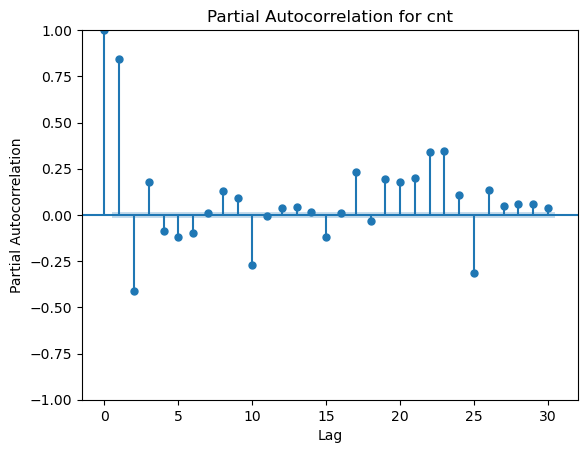

In [7]:
pacf_plot(df["cnt"], lags=30)

As it is visible, the biggest impact is provided by lag 2, 3, 24 and 25, so these lags will be used in the model.

In [8]:
selected_lags = [1, 2, 24, 25]
df = get_lag_features(df, "cnt", selected_lags)

In [9]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'hr_sin', 'hr_cos', 'mnth_sin',
       'mnth_cos', 'weekday_sin', 'weekday_cos', 'hr_spline_0', 'hr_spline_1',
       'hr_spline_2', 'hr_spline_3', 'hr_spline_4', 'hr_spline_5',
       'hr_spline_6', 'hr_spline_7', 'hr_spline_8', 'hr_spline_9',
       'hr_spline_10', 'hr_spline_11', 'hr_spline_12', 'hr_spline_13',
       'hr_spline_14', 'hr_spline_15', 'hr_spline_16', 'hr_spline_17',
       'hr_spline_18', 'hr_spline_19', 'hr_spline_20', 'hr_spline_21',
       'hr_spline_22', 'hr_spline_23', 'mnth_spline_0', 'mnth_spline_1',
       'mnth_spline_2', 'mnth_spline_3', 'mnth_spline_4', 'mnth_spline_5',
       'mnth_spline_6', 'mnth_spline_7', 'mnth_spline_8', 'mnth_spline_9',
       'mnth_spline_10', 'mnth_spline_11', 'weekday_spline_0',
       'weekday_spline_1', 'weekday_spline_2', 'weekday_spline_3',

In [10]:
# Check if lags are correct.

df[["cnt", "cnt_lag_1", "cnt_lag_2"]].tail(10)

,cnt,cnt_lag_1,cnt_lag_2
17369,247,203.0,224.0
17370,315,247.0,203.0
17371,214,315.0,247.0
17372,164,214.0,315.0
17373,122,164.0,214.0
17374,119,122.0,164.0
17375,89,119.0,122.0
17376,90,89.0,119.0
17377,61,90.0,89.0
17378,49,61.0,90.0


In [11]:
df["dteday"] = pd.to_datetime(df["dteday"])

In [12]:
# Last day of dataset
dt = df["dteday"].iloc[-1]

# Subtracting a month
dt_subtracted = dt - relativedelta(months=1)

print(f"Last datetime: {dt}")
print(f"Datetime a month earlier: {dt_subtracted}")

Last datetime: 2012-12-31 00:00:00
Datetime a month earlier: 2012-11-30 00:00:00


In [13]:
train = df[df["dteday"] <= "2012-11-30"]
test = df[df["dteday"] > "2012-11-30"]

In [14]:
# Creating a list of features to be used to train with - excluding features prone to leakage - e.g. temp, registered

feats = (["season", "yr", "mnth", "holiday", "weekday", "workingday"] +
         ["hr_sin", "hr_cos", "mnth_sin", "mnth_cos", "weekday_sin", "weekday_cos"] +
         [f"hr_spline_{i}" for i in range(24)] +
         [f"mnth_spline_{i}" for i in range(12)] +
         [f"weekday_spline_{i}" for i in range(7)] +
         [f"cnt_lag_{i}" for i in selected_lags])

In [15]:
X_train = train[feats]
X_test = test[feats]

X_train_ne = train[["season", "yr", "mnth", "hr"]]
X_test_ne = test[["season", "yr", "mnth", "hr"]]

y_train = train["cnt"]
y_test = test["cnt"]

In [16]:
# Baseline model - lgbm with default values and no engineered features added

lgb_baseline = LGBMRegressor(verbose=-1, random_state=42)


lgb_baseline.fit(X_train_ne, y_train)
print(lgb_baseline.get_params())


y_train_baseline = make_prediction(lgb_baseline,X_train_ne)
y_test_baseline = make_prediction(lgb_baseline,X_test_ne)


# Evaluate baseline
print("Train set evaluation", evaluate_model(y_train_baseline, y_train))
print("Test set evaluation", evaluate_model(y_test_baseline, y_test))


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1}
Train set evaluation {'mean_absolute_error': 62.15429464446715, 'root_mean_squared_error': 93.47640221592182, 'r2_score': 0.7362699439915376}
Test set evaluation {'mean_absolute_error': 81.33018867924528, 'root_mean_squared_error': 116.83595406263034, 'r2_score': 0.49728397655201584}


In [17]:
# Adding engineered features 

lgb = LGBMRegressor(verbose=-1)


lgb.fit(X_train, y_train)
print(lgb.get_params())


y_train_baseline = make_prediction(lgb,X_train)
y_test_baseline = make_prediction(lgb,X_test)


# Evaluate with engineered features
print("Train set evaluation", evaluate_model(y_train_baseline, y_train))
print("Test set evaluation", evaluate_model(y_test_baseline, y_test))


{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1}
Train set evaluation {'mean_absolute_error': 18.9340025244936, 'root_mean_squared_error': 29.280144497833835, 'r2_score': 0.9741237057492459}
Test set evaluation {'mean_absolute_error': 19.29245283018868, 'root_mean_squared_error': 30.600613950115267, 'r2_score': 0.9655150191307613}


Adding engineered features significantly improved the prediction on the test set.
Next step will be to optimize using grid search cross validation.
Main metric to be optimized for will be `neg_mean_absolute_error` - MAE which does not penalize for having some outlier prediction which are too far of from the original demand.

In [18]:
# Grid search to optimize parameters
lgb = LGBMRegressor(verbose=-1, random_state=42)

param_grid = {
    "max_depth":[-1, 5, 6, 7],
    "n_estimators": [50, 100, 150],    
    "num_leaves": [31, 63, 75, 97],     
}

tss = TimeSeriesSplit(n_splits=5, test_size=24*30, gap=24)
gscv = GridSearchCV(estimator=lgb,
                    param_grid=param_grid,
                    cv=tss,
                    scoring="neg_mean_absolute_error", verbose=10)

gscv.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV 1/5; 1/48] START max_depth=-1, n_estimators=50, num_leaves=31...............
[CV 1/5; 1/48] END max_depth=-1, n_estimators=50, num_leaves=31;, score=-33.871 total time=   0.2s
[CV 2/5; 1/48] START max_depth=-1, n_estimators=50, num_leaves=31...............
[CV 2/5; 1/48] END max_depth=-1, n_estimators=50, num_leaves=31;, score=-30.798 total time=   0.1s
[CV 3/5; 1/48] START max_depth=-1, n_estimators=50, num_leaves=31...............
[CV 3/5; 1/48] END max_depth=-1, n_estimators=50, num_leaves=31;, score=-37.193 total time=   0.2s
[CV 4/5; 1/48] START max_depth=-1, n_estimators=50, num_leaves=31...............
[CV 4/5; 1/48] END max_depth=-1, n_estimators=50, num_leaves=31;, score=-36.077 total time=   0.1s
[CV 5/5; 1/48] START max_depth=-1, n_estimators=50, num_leaves=31...............
[CV 5/5; 1/48] END max_depth=-1, n_estimators=50, num_leaves=31;, score=-25.669 total time=   0.2s
[CV 1/5; 2/48] START max_depth=-1, n_e

GridSearchCV(cv=TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=720),
             estimator=LGBMRegressor(random_state=42, verbose=-1),
             param_grid={'max_depth': [-1, 5, 6, 7],
                         'n_estimators': [50, 100, 150],
                         'num_leaves': [31, 63, 75, 97]},
             scoring='neg_mean_absolute_error', verbose=10)

In [19]:
print("\n The best estimator across all searched params:\n", gscv.best_estimator_)


 The best estimator across all searched params:
 LGBMRegressor(num_leaves=97, random_state=42, verbose=-1)


In [20]:
# Reatraining with new parameters

lgmb_best = gscv.best_estimator_

# Now you have the parameters with which you can initialize a new model
params = lgmb_best.get_params()

# Create a new model with best parameters
lgb = LGBMRegressor(**params)

lgb.fit(X_train, y_train)

LGBMRegressor(num_leaves=97, random_state=42, verbose=-1)

In [21]:
y_pred = lgb.predict(X_test)

In [22]:
evaluate_model(y_test, y_pred)

{'mean_absolute_error': 18.699628528443597,
 'root_mean_squared_error': 29.46367043817191,
 'r2_score': 0.9684091247479725}

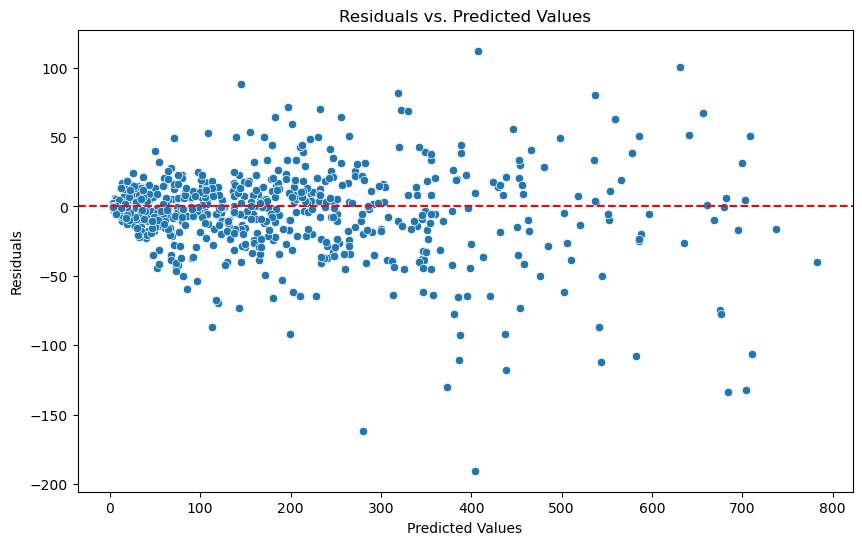

In [23]:
residual_plot(y_test, y_pred)

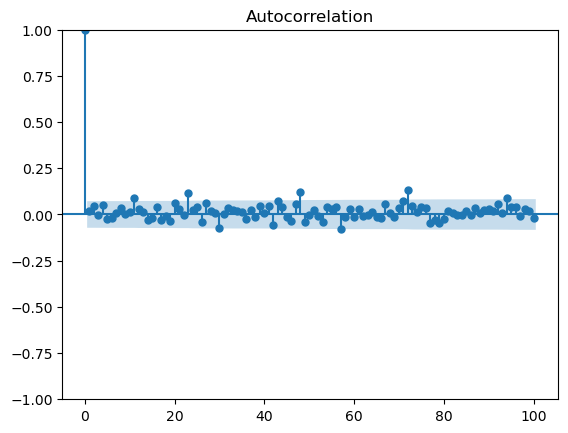

In [24]:
# Plottin autocorrelation of residuals

residuals = y_test - y_pred
plot_acf(residuals, lags=100)
plt.show()

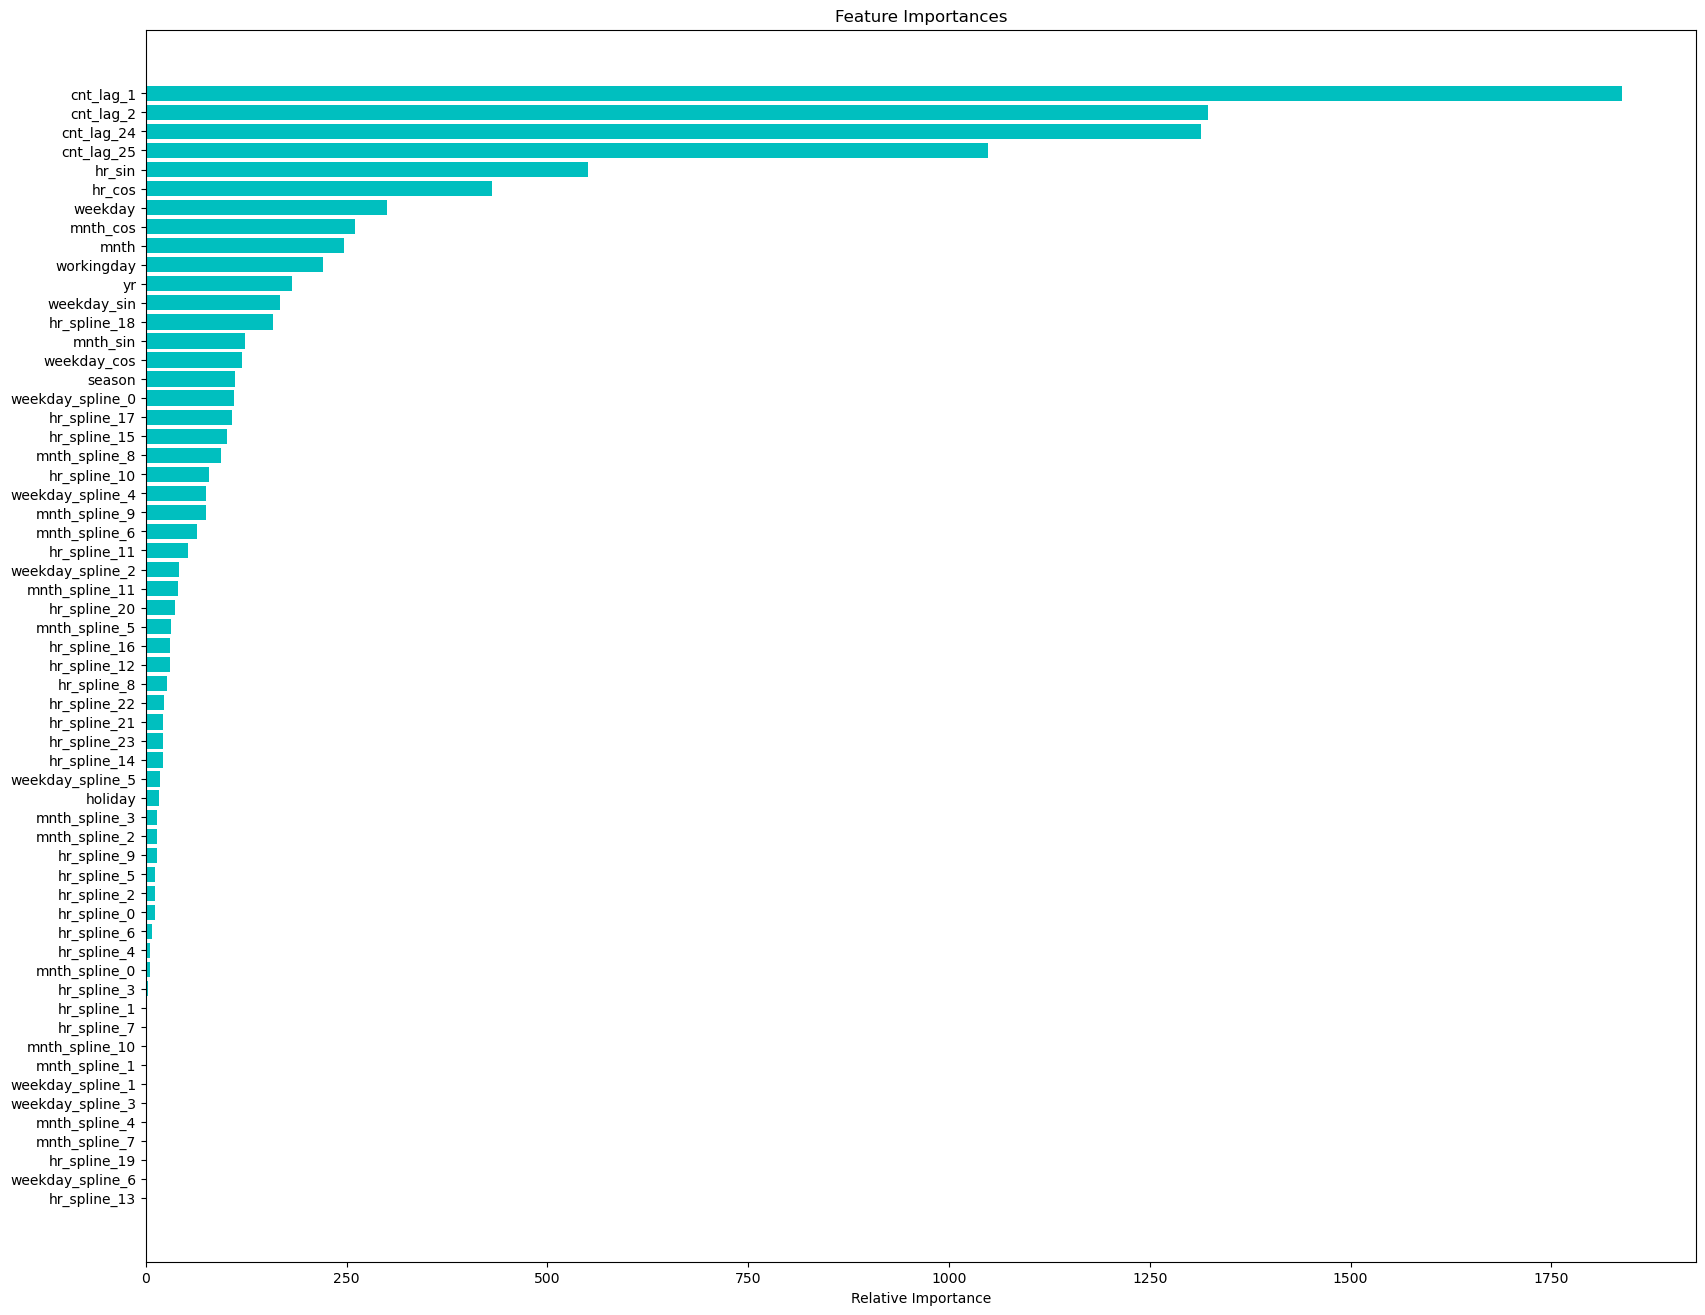

In [26]:
# Calculate Feature Importances

importances = lgb.feature_importances_
indices = np.argsort(importances)
feature_names = X_train.columns

plt.figure(figsize= (20, 16))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="c", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


We can see that there is still quite some room for improvement, using different optimization technique (even expanding the hyperparameter values in the gridsearch) or feature engineering different features could help improve this model. The biggest importance to the contribution of prediction have all 4 lag features.


In conclusion, the biggest impact on the performance can be attributed to the feature engineering while finetuning the model via grid search had some marginal impact.